<a href="https://colab.research.google.com/github/Zhen-Miao/PIC-snATAC/blob/main/vignettes/Run_PIC_on_human_brain_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run PIC on human brain data


## Step 1. Install packages
Here in this notebook, we show examples to run PIC test on human brain data. We need to install several packages first. This may take a while.

In [ ]:
install.packages('devtools')
install.packages('Seurat')
install.packages('Signac')
install.packages('data.table') ## (please make sure it is newer than 1.8)
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘textshaping’, ‘ragg’, ‘pkgdown’


Warning message in install.packages("devtools"):
“installation of package ‘textshaping’ had non-zero exit status”
Warning message in install.packages("devtools"):
“installation of package ‘ragg’ had non-zero exit status”
Warning message in install.packages("devtools"):
“installation of package ‘pkgdown’ had non-zero exit status”
Warning message in install.packages("devtools"):
“installation of package ‘devtools’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
BiocManager::install(c("GenomeInfoDb","Rsamtools","IRanges"))
devtools::install_github("Zhen-Miao/PIC-snATAC")
install.packages('Signac')

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.17 (BiocManager 1.30.20), R 4.3.0 (2023-04-21)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'GenomeInfoDb' 'Rsamtools' 'IRanges'”
Old packages: 'bit', 'bslib', 'devtools', 'digest', 'gert', 'highr', 'isoband',
  'jsonlite', 'knitr', 'pkgload', 'roxygen2', 'sys', 'tidyverse', 'whisker',
  'boot', 'foreign'

Skipping install of 'PICsnATAC' from a github remote, the SHA1 (5c479e4a) has not changed since last install.
  Use `force = TRUE` to force installation

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Step 2. Load packages

In [ ]:
library('data.table')
library('GenomicRanges')
library('Matrix')
library('PICsnATAC')
library('Seurat')
library('Signac')
library('GenomicRanges')


Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:data.table’:

    first, second


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges


At

## Step 3. Load data. 
Here, we have provided an example dataset from SNARE-seq2 human brain data (Bakken et al., _Nature_ 2021). We have loaded the data into a Seurat object. Please refer to the Seurat webpage and our source codes for additional details of this step. 

In [ ]:
brain = readRDS('/content/SNARE_seq2_human_brain_subset_Seurat_object.rds')

In this data subset, we have retained two cell types, GABAergic neurons and Glutamatergic neurons. In each cell type, we retained a random subset of 1000 cells. 

In [ ]:
table(brain@meta.data$level1)


    GABAergic Glutamatergic 
         1000          1000 

This dataset also contains sub-cell type annotated. 

In [ ]:
table(brain@meta.data$level1,brain@meta.data$level2)

               
                CGE-PoA ET projection IT projection MGE
  GABAergic         500             0             0 500
  Glutamatergic       0           500           500   0

## Step 4. Depth correction 
Next, we need to Compute the capturing probability to normalize the sequencing depth across cells. We provide functions to jointly estimate caputuring probability and peak open probability for each single cell. Please refer to our manuscript for additional details. Due to the limited RAM available in Google Colab, we have computed the values locally and provided an R object here

In [ ]:
## With sufficient resource (RAM), we should be able to run the following codes dircetly
#r_by_ct_out = get_r_by_ct_mat_pq(cell_type_set = unique(brain@meta.data$level1),
#                                r_by_c = brain[['ATAC']]@counts,
#                                 cell_type_labels = brain@meta.data$level1,
#                                 p_acc = 5e-5, q_acc = 5e-5,n_max_iter = 2000,
#                                 n_features_per_cell = dim(brain[['ATAC']]@counts)[1])

## for the completeness of the notebook, we saved the object and loaded it here
r_by_ct_out = readRDS('r_by_ct_out_human_brain_SNARE2.rds')


The output of this object includes a peak-by-cell-type matrix and a capturing rate vector for each cell. We will only need the second quantity for this step. 

In [ ]:
str(r_by_ct_out)

List of 2
 $ p_by_t: num [1:273099, 1:3] 0.00466 0.06941 0.00181 0.14453 0.999 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:3] "GABAergic" "Glutamatergic" "Non-Neuronal"
 $ q_vec : Named num [1:30738] 0.505 0.361 0.409 0.321 0.356 ...
  ..- attr(*, "names")= chr [1:30738] "MOP16_AAACATCGAACCGAGACGAACTTA" "MOP16_AAACATCGAACGTGATCAACCACA" "MOP16_AAACATCGAATCCGTCCTCAATGA" "MOP16_AAACATCGACACGACCCGACTGGA" ...


In [ ]:
## to obtain the caputring rate vector 
cap_rate = r_by_ct_out$q_vec[colnames(brain[['ATAC']]@counts)]


## Step 5. Compute DAR
We provided a parametric framework for identifying DARs between two cell types, based on the model of insertion rate and observed PIC counts. Again, due to the limited RAM available in Google Colab, we have computed the values locally and provided an R object here

We will only compute the p values for peaks with at least four cells accessible. 

In [ ]:
pic_mat = brain[['ATAC']]@counts
rs = rowSums(pic_mat)
pic_mat = pic_mat[rs >= 4,] ## 217657

In [ ]:
## With sufficient resource (RAM), we should be able to run the following codes dircetly
# ## for large matrices, to get a faster computation, we run it for each subset of data
# n_per_iter = 20000
# n_iter = ceiling(nrow(pic_mat)/n_per_iter)
# p_vals_GABA = rep(list(), length = n_iter)
# 
# for(iter in 11:n_iter){
#   f_start = 1 + (iter-1)*n_per_iter
#   f_end = min(nrow(pic_mat), iter*n_per_iter)
#   
#   p_vals_GABA[[iter]] = DAR_by_LRT(pic_mat = pic_mat[f_start:f_end,],
#                          capturing_rates = cap_rate,
#                          cell_type_labels = pbmc@meta.data$level1,
#                          plen = plen2[f_start:f_end],
#                          n_cores = 5)
#   print(iter)
# }
#   saveRDS(p_vals_GABA, 'p value GABAergic vs Glutamatergic.rds')

p_vals_GABA = readRDS('p value GABAergic vs Glutamatergic.rds')
p_vals_GABA = unlist(p_vals_GABA)
names(p_vals_GABA) = rownames(pic_mat)
p_adj = p.adjust(p_vals_GABA, method = 'fdr')


Now we can compute fold change of accessibility between two groups

In [ ]:
cell_type_set <- unique(brain@meta.data$level1)
cell_types <- brain@meta.data$level1
## mean accessibility values after correcting for sequencing depth
rm1 <- rowSums(pic_mat[,cell_types == cell_type_set[1] ] %*%
                 diag(1 / cap_rate[cell_types == cell_type_set[1] ])) / 
  sum(cell_types == cell_type_set[1])
rm2 <- rowSums(pic_mat[,cell_types == cell_type_set[2] ] %*%
                 diag(1 / cap_rate[cell_types == cell_type_set[2] ])) / 
  sum(cell_types == cell_type_set[2])

## sequencing depth corrected log fold change
log_fc_depth_corrected = log(rm2+0.0001) - log(rm1+0.0001) # 0.0001 is added to prevent log(0)



In [ ]:
## we can then check the two cell types, so that the peaks specific to
## the first cell type will have a positive log fold change, peaks specific
## to the second cell type will have a negative log fold change
print(cell_type_set)

[1] "GABAergic"     "Glutamatergic"


In [ ]:
## load ggplot 2
library('ggplot2')


We can summarize the data for some visualizations

In [ ]:
## create data.frame for visualizing the log fold change and p value 
df = data.frame(m_log_p_val = -log(p_adj),
                log_fc = log_fc_depth_corrected)
df$is_DAR = p_adj < 0.05
head(df)

,m_log_p_val,log_fc,is_DAR
,<dbl>,<dbl>,<lgl>
chr1-181123-181710,0.1144012,0.1856274,FALSE
chr1-190925-191831,7.2956156,-2.0922724,TRUE
chr1-605341-605765,0.5202930,0.5725281,FALSE
chr1-629800-630435,4.4562768,-0.5892030,TRUE
chr1-633543-634316,54.6178299,-0.5263550,TRUE
chr1-778337-780154,0.4677176,0.2622143,FALSE


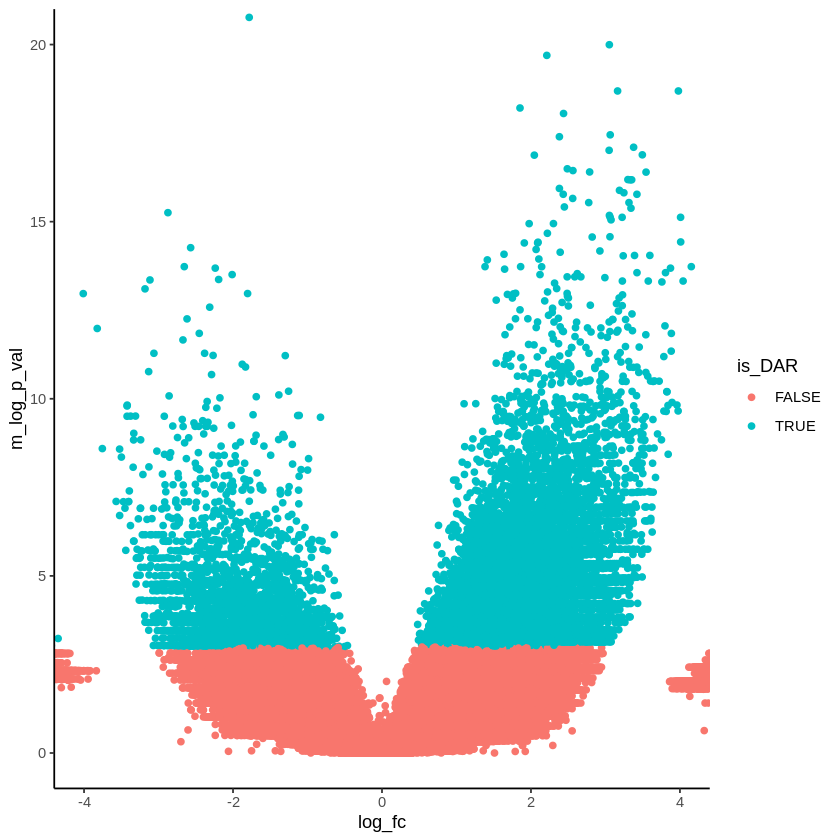

In [ ]:
ggplot(df) +
  geom_point(mapping = aes(x = log_fc, y = m_log_p_val, color = is_DAR))+
  coord_cartesian(xlim = c(-4,4), ylim = c(0,20))+
  theme_classic()

We can then extract the list of DARs for each cell type and then run motif enrichment or examine their nearest genes and conduct functional analysis.

## Processed data
Some processed data can be downloaded here:
https://www.dropbox.com/s/630ik7s0ecop1kf/SNARE_seq2_human_brain_subset_Seurat_object.rds?dl=0

https://www.dropbox.com/s/55v0b5roqsjru2p/r_by_ct_out_human_brain_SNARE2.rds?dl=0 

https://www.dropbox.com/s/ldnf0vaqis1mms6/p%20value%20GABAergic%20vs%20Glutamatergic.rds?dl=0 

## Reference 
For this worksheet, we used the following public data:
Bakken, Trygve E., et al. "Comparative cellular analysis of motor cortex in human, marmoset and mouse." _Nature_ 598.7879 (2021): 111-119.

If you used PIC-snATAC counting in your analysis, please cite our manuscript:

Miao Z, Kim J. Is single nucleus ATAC-seq accessibility a qualitative or quantitative measurement?. _bioRxiv_. 2022.